In [ ]:
pip install kagglehub

In [ ]:
import kagglehub
import os
import shutil
import random
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [ ]:
# Baixar o dataset
path = kagglehub.dataset_download("arifmia/animal")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/arifmia/animal/versions/1


In [ ]:
# Listar os arquivos no diretório raiz do dataset
print("Arquivos no dataset_path: ", os.listdir(path))

# Criar diretórios para classes específicas
output_path = "./filtered_dataset/"
os.makedirs(os.path.join(output_path, "cat"), exist_ok=True)
os.makedirs(os.path.join(output_path, "dog"), exist_ok=True)


Arquivos no dataset_path:  ['Dataset']


In [ ]:
# Caminho para o diretório raiz do dataset
dataset_path = path + "/Dataset/train/"

# Listar todas as pastas no diretório raiz
animal_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

In [ ]:
# Contar as imagens em cada pasta
print("Pasta e número de imagens:")
sufficient_images_folders = []
for folder in animal_folders:
    folder_path = os.path.join(dataset_path, folder)
    image_count = len([img for img in os.listdir(folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))])

    print(f"{folder}: {image_count} imagens")

    if image_count >= 100:
        sufficient_images_folders.append(folder)

# Exibir as pastas com pelo menos 100 imagens
print("\nPastas com pelo menos 100 imagens:")
print(sufficient_images_folders)


Pasta e número de imagens:
cat: 304 imagens
horse: 299 imagens
dog: 424 imagens

Pastas com pelo menos 100 imagens:
['cat', 'horse', 'dog']


In [ ]:
# Caminhos para os diretórios das classes
cat_dir = os.path.join(dataset_path, "cat")
dog_dir = os.path.join(dataset_path, "dog")

# Copiar imagens filtradas para os novos diretórios
for src_dir, class_name in [(cat_dir, "cat"), (dog_dir, "dog")]:
    dest_dir = os.path.join(output_path, class_name)
    for img_file in list(os.listdir(src_dir))[:100]:
        shutil.copy(os.path.join(src_dir, img_file), dest_dir)


In [ ]:
# Função para redimensionar imagens
def resize_images(class_dir):
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        try:
            with Image.open(img_path) as img:
                img = img.resize((224, 224))  # Redimensionar para 224x224 pixels
                img.save(img_path)  # Salvar a imagem redimensionada
        except Exception as e:
            print(f"Erro ao processar {img_path}: {e}")

# Redimensionar imagens para ambas as classes
resize_images(os.path.join(output_path, "cat"))
resize_images(os.path.join(output_path, "dog"))


In [ ]:
# Verifique se o dataset está organizado e redimensionado corretamente
for class_name in ["cat", "dog"]:
    class_dir = os.path.join(output_path, class_name)
    print(f"{class_name} - Total imagens: {len(os.listdir(class_dir))}")

cat - Total imagens: 100
dog - Total imagens: 100


In [ ]:
# Data Augmentation para gerar mais imagens de treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Dividindo 80% treino e 20% validação
)

# Data Generator para o conjunto de treino
train_generator = train_datagen.flow_from_directory(
    output_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

# Data Generator para o conjunto de validação
validation_generator = train_datagen.flow_from_directory(
    output_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
# Confirmar número de classes
print("Classes detectadas:", train_generator.class_indices)

Classes detectadas: {'cat': 0, 'dog': 1}


In [ ]:
# Modelo VGG16 pré-treinado
# Carregar modelo pré-treinado VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar apenas as últimas camadas para fine-tuning
for layer in base_model.layers[:-2]:
    layer.trainable = False


In [ ]:
# Adicionar camadas customizadas
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)  # Adicionado L2 Regularization
#x = Dropout(0.05)(x)  # Dropout para evitar overfitting
x = Dense(128, activation='relu')(x)
#x = Dense(128, activation='relu', kernel_regularizer=l2(0.00001))(x)
x = Dropout(0.25)(x)
#x = Dense(64, activation='relu')(x)
x = Dense(train_generator.num_classes, activation='softmax')(x)  # Saída com duas classes: 'cat' e 'dog'

In [ ]:
# Criar o modelo final
model = Model(inputs=base_model.input, outputs=x)

# Compilar o modelo com uma Learning Rate menor
#optimizer = Adam(learning_rate=0.00005)
optimizer = 'adam'
# Compilar o modelo
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks para evitar overfitting e ajustar a taxa de aprendizado
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.65, patience=3, min_lr=1e-4)

# Treinar o modelo com os geradores
model.fit(train_generator, validation_data=validation_generator, epochs=10, callbacks=[early_stopping, reduce_lr])

# Salvar os pesos do modelo
model.save("trained_model.keras")
print("Modelo salvo como 'trained_model.keras")

# Representação da estrutura e dos parâmetros aprendidos que serão usados ​​para predição.
model.summary()

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 427ms/step - accuracy: 0.8766 - loss: 0.5451 - val_accuracy: 0.8000 - val_loss: 0.8315 - learning_rate: 0.0010
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - accuracy: 0.9436 - loss: 0.1494 - val_accuracy: 0.8750 - val_loss: 0.5723 - learning_rate: 0.0010
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - accuracy: 0.9854 - loss: 0.0692 - val_accuracy: 0.9250 - val_loss: 0.4157 - learning_rate: 0.0010
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 270ms/step - accuracy: 0.9745 - loss: 0.1428 - val_accuracy: 0.7750 - val_loss: 0.9221 - learning_rate: 0.0010
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.9508 - loss: 0.1019 - val_accuracy: 0.9250 - val_loss: 0.4628 - learning_rate: 0.0010
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step - accuracy: 0.9763 - loss: 0.0541 - val_accuracy: 0.8500 - val_loss: 0.6203 - learning_rate: 0.0010
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.9658 - loss: 0.0877 - 

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 38,802,120 (148.02 MB)

 Trainable params: 8,815,746 (33.63 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

 Optimizer params: 17,631,494 (67.26 MB)

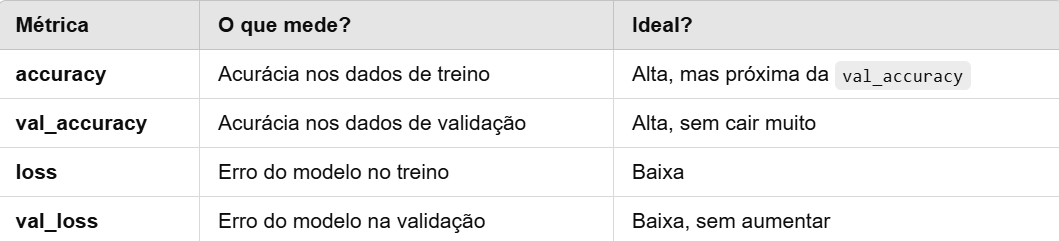



***1️⃣ Se a acurácia da validação começar a cair:***

* Se a acurácia de treino for alta (ex: 99%), mas a de validação for muito menor e começar a cair (ex: 85% → 75%), o modelo está claramente overfitado e pode falhar em novos dados.

***2️⃣ Se a perda da validação (val_loss) aumentar enquanto a do treino cai:***

* Se loss no treino continuar diminuindo (0.1 → 0.05 → 0.02), mas val_loss aumentar (0.2 → 0.4 → 0.6), o modelo está memorizando os dados de treino e não conseguirá prever bem em novos dados.


*   Se loss e val_loss descem juntos → O modelo está aprendendo bem.
*   Se loss desce, mas val_loss sobe → O modelo está overfitting.
*   Se accuracy e val_accuracy sobem juntas → O modelo está generalizando bem.


***Se precisar de ajustes no treinamento:***


*   Aumentar dropout para reduzir overfitting.
*   Aplicar data augmentation para melhorar a generalização.
*   Treinar por mais épocas se o modelo ainda não convergiu.

***🔧 Ajustes Implementados***


*   Data Augmentation → Aumenta a diversidade do dataset artificialmente.
*   Dropout (Regularização) → Evita que o modelo memorize padrões específicos.
*   L2 Regularization → Penaliza pesos muito grandes para melhorar a generalização.
*   Early Stopping → Para o treinamento quando o modelo para de melhorar.
*   Learning Rate Scheduling → Ajusta a taxa de aprendizado ao longo do tempo.


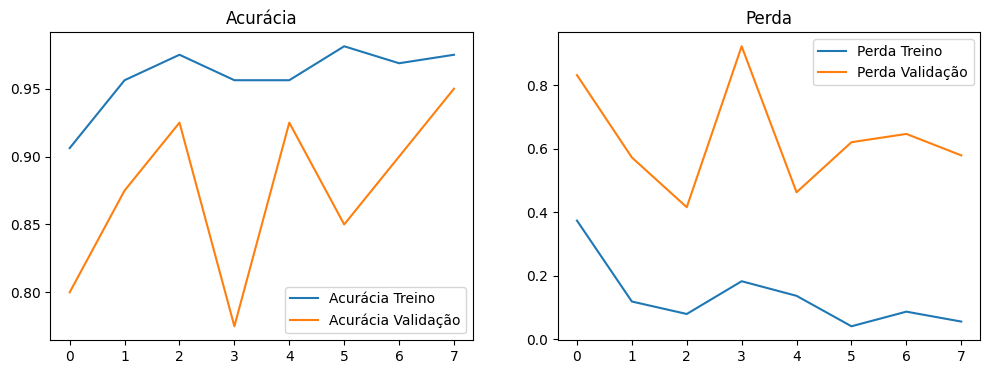

In [ ]:
# Plotando os resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

model_history = model.history

ax1.plot(model_history.history['accuracy'], label='Acurácia Treino')
ax1.plot(model_history.history['val_accuracy'], label='Acurácia Validação')
ax1.set_title('Acurácia')
ax1.legend()

ax2.plot(model_history.history['loss'], label='Perda Treino')
ax2.plot(model_history.history['val_loss'], label='Perda Validação')
ax2.set_title('Perda')
ax2.legend()

plt.show()

In [ ]:
# Carregar o modelo salvo para teste
modelo_carregado = load_model("trained_model.keras")
print("Modelo carregado para verificação")

Modelo carregado para verificação


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


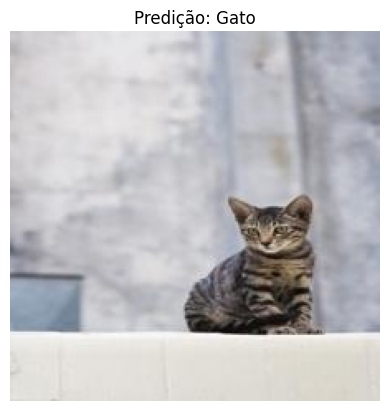

In [ ]:
# Caminho para a pasta com imagens de gatos
image_folder = "./filtered_dataset/cat"

# Escolher uma imagem aleatória dentro da pasta
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
if not image_files:
    raise ValueError("Nenhuma imagem encontrada na pasta!")

# Escolher uma imagem aleatória da lista
selected_image = np.random.choice(image_files)
image_path = os.path.join(image_folder, selected_image)

# Carregar e processar a imagem
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.0  # Normalizar a imagem
img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão batch

# Fazer a predição com o modelo carregado
prediction = modelo_carregado.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)  # Obtém a classe com maior probabilidade

# Exibir a imagem e o resultado
plt.imshow(img)
plt.axis("off")
plt.title(f"Predição: {'Gato' if predicted_class[0] == 0 else 'Cachorro'}")
plt.show()